# Kalman example 5

A simple 2d example to test etkf

In [1]:
import xarray as xr
from IPython.display import HTML
import matplotlib.pyplot as plt

from dlm.plotutils import animate
from dlm.modelutils import matern32L

# Kalman functions etc collected to one file kalman.py
from kalman import *

from analyze.animate import create_animation


Generate small enough 2d data

In [2]:
nx = 10
ny = 10
ntime = 20

u = np.ones((ntime, ny, nx))
v = np.ones((ntime, ny, nx))

u[-15:] = -1
v[-14:] = -1
u[10:] = 1
v[10:] = 1
u[14:] = -1
v[14:] = -1

data = np.ones((ntime, ny, nx)) * 0.2
data[0, 1:3, 1:3] = 1.0

for i in range(ntime - 1):
    if i == 7:
        data[i, 8:9, 8:9] = 1.0
    data[i + 1] = warp_simple(data[i], u[i], v[i])

In [3]:
HTML(animate(xr.DataArray(data, dims = ['time', 'y', 'x'])).to_jshtml())

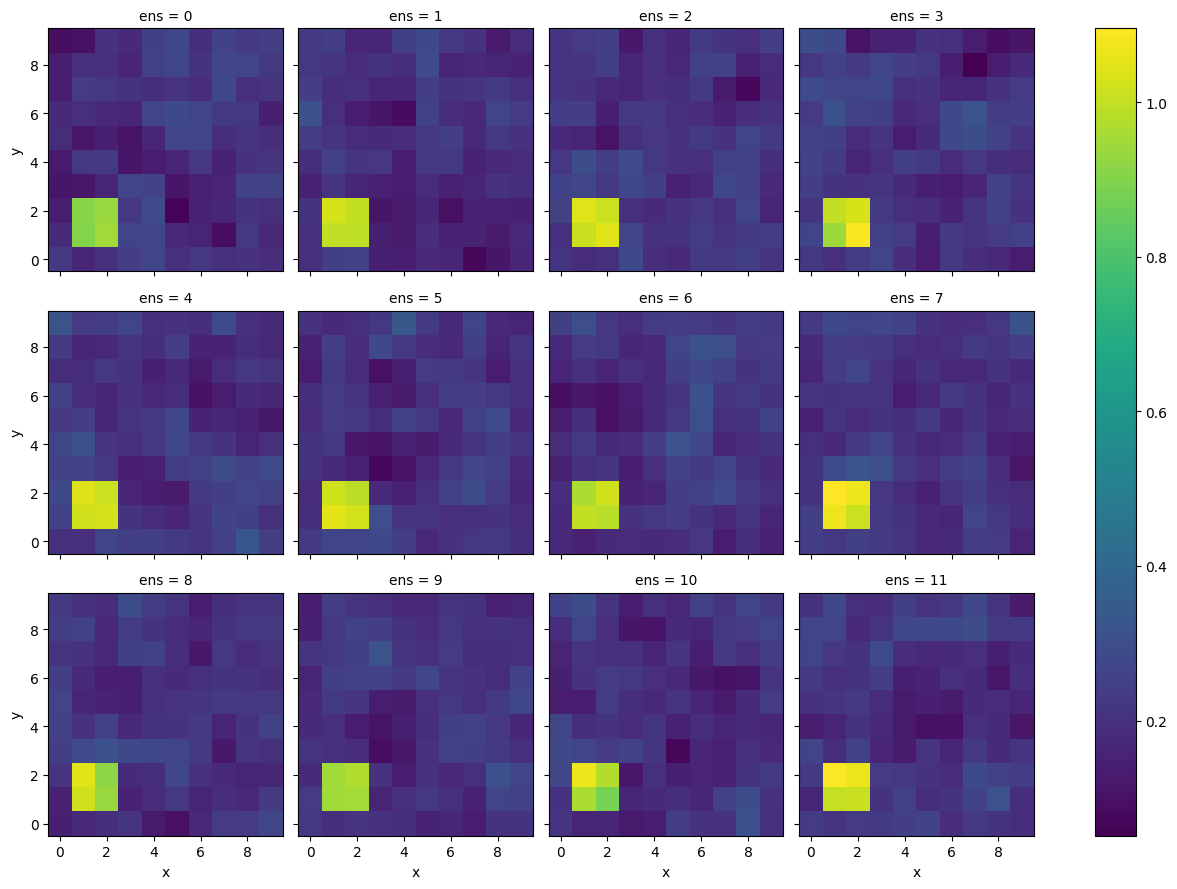

In [4]:
nens = 200
L = matern32L(nx, ny, h=1, l=1, sig=0.05, format='csc')
H = sp.eye(ny*nx)

ysig = 0.1
ystd = np.ones((ny, nx)) * ysig
obs = data[1:]
obs = obs + np.random.randn(*obs.shape) * ysig

# some missing observations
obs[:,6] = np.nan
obs[:,3] = np.nan

xens = np.empty((ny, nx, nens))
x0 = data[0]

# generate initial ensemble
for i in range(nens):
    xens[:, :, i] = x0 + sp.linalg.spsolve(L, np.random.randn(nx*ny)).reshape(ny, nx)

# plot initial ensemble
xr.DataArray(xens[:,:,:12], dims=['y', 'x', 'ens']).plot.pcolormesh(
    x='x', y='y', col='ens', col_wrap=4, cmap='viridis', robust=False
)
plt.show()

In [7]:

xnew = xens.copy()
xout = np.empty((ntime-1, nx, ny, nens))

ystd2 = ystd.copy().ravel() * 1.1  # make ystd smaller to see what happens

for i in range(ntime-1):
    M = genM_warp(u[i], v[i])
    igood = np.isfinite(obs[i])
    xnew = etkf_step(xnew.reshape(-1, nens), M, L,
                     obs[i][igood].ravel(),
                     H.tocsc()[igood.ravel()],
                     ystd2[igood.ravel()],
                     inflation=1.0).reshape(ny, nx, -1)
    xout[i] = xnew

What happens at a point near the centre.

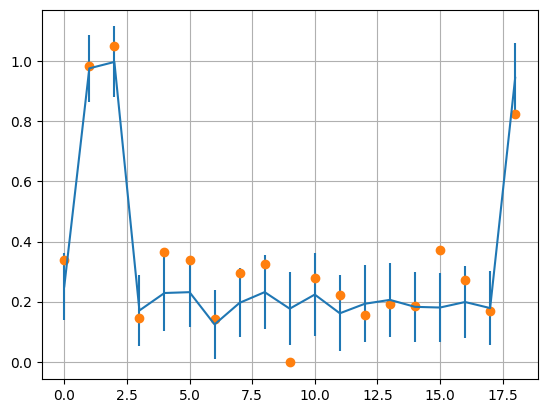

In [8]:
ix = 4
iy = 4

xout_mean = xout.mean(axis=3)
xout_std = xout.std(axis=3)
time = np.arange(ntime-1)

plt.errorbar(time, xout_mean[:, iy, ix], 2*xout_std[:, iy, ix], label='fit')
plt.plot(time, obs[:, iy, ix], 'o', label='obs')
plt.grid()
plt.show()

In [38]:
create_animation(xout_mean, np.stack([u, v]).transpose(1,0,2,3)[1:],
                 title=f'Nens = {nens}',
                 extent=None, data2=obs, vlim=[-0.1,2], skip=1)

## Localization

Make a larger domain

In [38]:
nx = 40
ny = 40
ntime = 20

u = np.ones((ntime, ny, nx)) * 2
v = np.ones((ntime, ny, nx)) * 2

u[9:] = -2
v[7:] = -2
u[14:] = 1
v[13:] = 1
#u[14:] = -1
#v[14:] = -1

L = matern32L(nx, ny, h=1, l=4, sig=0.01, format='csc')

data = np.ones((ntime, ny, nx)) * 0.1
data[0, 2:7, 2:7] = 1.0

for i in range(ntime - 1):
    #if i == 7:
    #    data[i, 8:9, 8:9] = 1.0
    data[i + 1] = warp_simple(data[i], u[i], v[i])
    data[i + 1] += sp.linalg.spsolve(L, np.random.randn(nx*ny)).reshape(ny, nx)

In [39]:
HTML(animate(xr.DataArray(data, dims = ['time', 'y', 'x'])).to_jshtml())

In [44]:
nens = 200

H = sp.eye(ny*nx)

ysig = 0.1
ystd = np.ones((ny, nx)) * ysig
obs = data[1:]
obs = obs + np.random.randn(*obs.shape) * ysig

# some missing observations
obs[:,10:12] = np.nan
obs[:,17:19] = np.nan

xens = np.empty((ny, nx, nens))
x0 = data[0]

# generate initial ensemble
for i in range(nens):
    xens[:, :, i] = x0 + sp.linalg.spsolve(L, np.random.randn(nx*ny)).reshape(ny, nx)

In [45]:
from dlm.modelutils import view_and_ind3

nens = xens.shape[-1]
xout = np.empty((ntime-1, ny, nx, nens))

# generate 10 x 10 views to the data
_, iv = view_and_ind3(data, 10, 10, flatten=True)

xnew = xens.copy()
for i in range(ntime-1):
    M = genM_warp(u[i], v[i])
    xnew = M @ xnew.reshape(-1, nens)

    for j in range(iv.shape[0]):
        obsij = obs[i].ravel()[iv[j]]
        ystdij = ystd.ravel()[iv[j]]
        igood = np.isfinite(obsij)
        xnew[iv[j]] = etkf_step(xnew[iv[j]], None, L[iv[j]][:, iv[j]],
                     obsij[igood],
                     H.tocsc()[:, iv[j]][igood],
                     ystdij[igood],
                     inflation=1.0)

    xout[i] = xnew.reshape(ny, nx, -1)

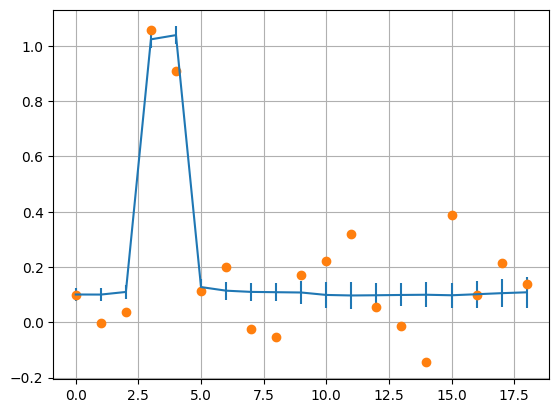

In [46]:

ix = 12
iy = 13

xout_mean = xout.mean(axis=3)
xout_std = xout.std(axis=3)
time = np.arange(ntime-1)

plt.errorbar(time, xout_mean[:, iy, ix], 2*xout_std[:, iy, ix], label='fit')
plt.plot(time, obs[:, iy, ix], 'o', label='obs')
plt.grid()
plt.show()

In [47]:
create_animation(xout_mean, np.stack([u, v]).transpose(1,0,2,3)[1:],
                 title=f'Nens = {nens}',
                 extent=None, data2=obs, vlim=[-0.1,2], skip=4)